In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

## Load extracted features and df

In [4]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [5]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 1), 'features')

def load_subject_time_feature(subj, time_steps, normalize=True):
    feature_loaded = []
    subj_result_folder = os.path.join(DEFAULT_FEATURE_FOLDER, f'{int(subj)}')
    subj_combined_feature_path = os.path.join(subj_result_folder, 'combined')
    for tid in time_steps:
        loaded = np.load(os.path.join(subj_combined_feature_path, f'{tid}.npy'))
        feature_loaded.append(loaded)
    features = np.mean(feature_loaded, axis=0) # time average

    if normalize:
        # Z-score normalization
        means = np.mean(features, axis=0)  # Mean of each column
        stds = np.std(features, axis=0)    # Standard deviation of each column
        features = (features - means) / (stds + 1e-5)
        
    # also the behavior data
    behavior_data = pd.read_csv(os.path.join(subj_result_folder, 'behavior.csv'))

    return features, behavior_data

In [6]:
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

## Precompute the difference table

In [7]:
from utils.distrib import ValueRangeManager, OriDistribModel, incorporate_distributions
from copy import deepcopy

example_base_params = {"w": 0.14, "k_base": 27, "alpha": 1.0, "beta": 0.0,}
value_manager = ValueRangeManager(np.arange(180))
base_distrib = OriDistribModel(value_manager, example_base_params)

In [8]:
all_oris = np.arange(180)
all_distrib = base_distrib.loc(all_oris)

In [9]:
# apply some smoothing
from scipy.ndimage import gaussian_filter1d

def gaussian_filter_distrib(distrib, sigma):
    smoothed = gaussian_filter1d(distrib, sigma=sigma, axis=1, mode='wrap')
    smoothed = smoothed / np.sum(smoothed, axis=1, keepdims=True)
    return smoothed

# all_distrib = gaussian_filter_distrib(all_distrib, sigma=15)

In [10]:
from scipy.spatial.distance import pdist, cdist, jensenshannon, squareform

def precomput_stim_dists(distrib, method):
    if method == 'jsd':
        dists = squareform(pdist(distrib, metric=jensenshannon))
        dists = dists / np.log(2)
    elif method == 'cos':
        distrib_normalized = distrib / np.linalg.norm(distrib, axis=1, keepdims=True)
        similarity = np.dot(distrib_normalized, distrib_normalized.T)
        dists = 1 - similarity
    elif method == 'euc':
        dists = cdist(distrib, distrib, 'euclidean')
    else:
        raise ValueError(f'Unknown method {method}')

    return dists

(array([  636.,   614.,   644.,   584.,   654.,   620.,   624.,   654.,
          672.,   672.,   718.,   736.,   798.,   844.,   918.,   998.,
         1142.,  1408.,  2364., 16100.]),
 array([0.        , 0.05217422, 0.10434844, 0.15652265, 0.20869687,
        0.26087109, 0.31304531, 0.36521952, 0.41739374, 0.46956796,
        0.52174218, 0.5739164 , 0.62609061, 0.67826483, 0.73043905,
        0.78261327, 0.83478748, 0.8869617 , 0.93913592, 0.99131014,
        1.04348435]),
 <BarContainer object of 20 artists>)

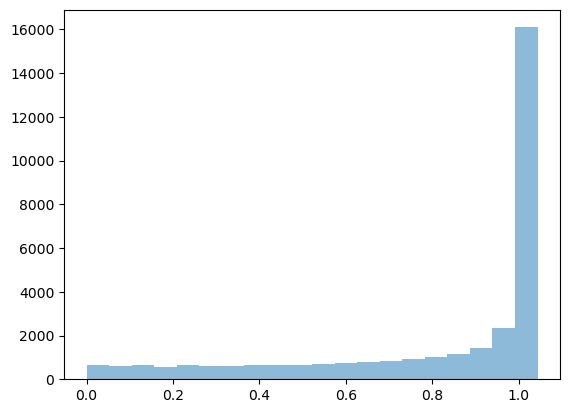

In [11]:
all_ori_dists = precomput_stim_dists(all_distrib, 'jsd')
plt.hist(all_ori_dists.flatten(), bins=20, alpha=0.5)

## Apply RSA within a certain condition

In [12]:
from utils.distrib import ValueRangeManager, OriDistribModel, incorporate_distributions
from copy import deepcopy

class RepresentationModel:
    def __init__(self, base_params):
        self.value_manager = ValueRangeManager(np.arange(180))
        # base distrib
        self.base_distrib = OriDistribModel(self.value_manager, base_params)
        # distrib to incorporate SD
        sd_distrib_params = deepcopy(base_params)

    def get_representation(self, data):
        return self.base_distrib.loc(data)

In [13]:
distrib_params = {"w": 0.14, "k_base": 27, "alpha": 1.0, "beta": 0.0,}
RepModel = RepresentationModel(distrib_params)

In [14]:
from abc import ABC, abstractmethod
from utils.distrib import color_smart_diff, color_smart_diff_outer
from scipy.spatial.distance import cdist

smart_diff = lambda x1, x2: color_smart_diff(x1, x2, vmin=-90, vmax=90)
smart_diff_outer = lambda x1, x2: color_smart_diff_outer(x1, x2, vmin=-90, vmax=90)

class DistFunctions:
    """ define all distance function """
    @classmethod
    def diff(cls, x1, x2, dist_name, pairwise):
        if dist_name == 'cos':
            return cls.cos_diff(x1, x2, pairwise)
        elif dist_name == 'euc':
            return cls.euclidean_diff(x1, x2, pairwise)
        else:
            raise NotImplementedError(f'Unknown distance {dist_name}')

    @classmethod
    def cos_diff(cls, x1, x2, pairwise):
        x1 = x1 / np.linalg.norm(x1, axis=-1, keepdims=True)
        x2 = x2 / np.linalg.norm(x2, axis=-1, keepdims=True)
        if pairwise:
            dists = cdist(x1, x2, metric='cosine')
        else:
            similarity = np.sum(x1 * x2, axis=-1)
            dists = 1 - similarity
        return dists

    @classmethod
    def euclidean_diff(cls, x1, x2, pairwise):
        if pairwise:
            dists = cdist(x1, x2, metric='euclidean')
        else:
            diffs = x1 - x2
            dists = np.linalg.norm(diffs, axis=-1)
        return dists

class RSAHelper(ABC):
    @abstractmethod
    def compute_channel_pattern(self, neural_data, *args):
        pass

    @abstractmethod
    def compute_one_subj_corr(self, neural_data, *args):
        # for each trial
        # compute the pattern excluding that trial
        # compute the correlation for that trial over time
        # note that for SD: replace 'nan' previous response with current stim
        pass


class RepRSAHelper(RSAHelper):
    def __init__(self, channels, channel_k, rep_model: RepresentationModel):
        self.rep_model = rep_model
        self.channels = np.arange(channels) * (180 // channels)
        self.channel_k = channel_k
        self.channel_resps = self.rep_model.get_representation(self.channels) #N_CHANN * 180
        

    def compute_channel_pattern(self, neural_data, stim_rep): 
        # compute their diff with channels
        # result: N x c
        data_channel_diff = DistFunctions.diff(
            stim_rep, self.channel_resps, dist_name='cos', pairwise=True)

        # channel weights
        data_channel_weights = np.exp((1 - data_channel_diff) * self.channel_k)
        data_channel_weights = data_channel_weights / np.sum(data_channel_weights, axis=1, keepdims=True)

        # compute channel-wise pattern
        channel_patterns = np.tensordot(data_channel_weights.T, neural_data, axes=(1, 0)) # neural data may have >=2 dimensions
        channel_weights = np.sum(data_channel_weights, axis=0)

        # normalize: (by weights)
        weight_safe = np.where(channel_weights == 0, 1, channel_weights)
        shape_expansion = [slice(None)] + [None] * (channel_patterns.ndim - 1)
        expanded_weights = weight_safe[tuple(shape_expansion)]  # Shape: c x ...
        normalized_channel_pattern = channel_patterns / expanded_weights

        return normalized_channel_pattern, channel_weights

    def compute_trial_n(self, neural_data, stim_rep, cur_trial_id, dist_method):        
        target_mask = np.zeros(len(neural_data)).astype(bool)
        target_mask[cur_trial_id] = True

        # get the target
        target_data = neural_data[target_mask]
        target_stim_rep = stim_rep[target_mask]

        # get the rest
        rest_data = neural_data[~target_mask]
        rest_stim_rep = stim_rep[~target_mask]

        # compute the pattern from the rest
        rest_channel_pattern, rest_channel_weights = self.compute_channel_pattern(rest_data, rest_stim_rep)

        # the diff between channel pattern and target pattern
        neural_diffs = DistFunctions.diff(
            rest_channel_pattern, target_data, 
            dist_name=dist_method, pairwise=False)

        # the diff between channel and target corresponding stims
        stim_diffs = DistFunctions.diff(
            self.channel_resps, target_stim_rep, 
            dist_name='cos', pairwise=False)

        # filter out missing channel?
        valid_channel_mask = rest_channel_weights > 0
        neural_diffs = neural_diffs[valid_channel_mask]
        stim_diffs = stim_diffs[valid_channel_mask]
        
        # compute the correlation
        corr = np.corrcoef(stim_diffs, neural_diffs, rowvar=False)[0, 1:]  # Shape: (T,)
        return corr

    def compute_one_subj_corr(self, neural_data, target, dist_method):
        valid_mask = ~np.isnan(target)
        neural_data = neural_data[valid_mask]
        target = target[valid_mask]

        n_trials = len(neural_data)
        corr_scores = []

        target_rep = self.rep_model.get_representation(target)

        for trial_id in range(n_trials):
            # print(trial_id)
            corr = self.compute_trial_n(
                neural_data, target_rep, trial_id, dist_method)
            corr_scores.append(corr)
        
        # compute the average
        corr_scores = np.array(corr_scores) 

        return corr_scores


In [15]:
rsa_configs = {
    "channels": 18, # number of channels
    "channel_k": 5, # to compute weight for channels
}
rsa_helper = RepRSAHelper(**rsa_configs, rep_model=RepModel)

In [16]:
ALL_TIME_STEPS = np.arange(200)

def conditional_rsa_subj(subj, lmb, feature_mask, y_name, feature_dist_method):
    # masking
    fetched_features = []
    ys = None
    for t in ALL_TIME_STEPS:
        features, behav_df = load_subject_time_feature(subj, [t,])
        mask = lmb(behav_df) & ~np.isnan(behav_df[y_name].to_numpy())

        if np.sum(mask) >= 2:
            features = features[mask]
            behav_df = behav_df[mask]

            # get the target
            ys = behav_df[y_name].to_numpy()

            # fetch only relevant features
            features = features[:, feature_mask]
            fetched_features.append(features)

    if len(fetched_features) == 0:
        # there could be empty case...
        return None

    fetched_features = np.stack(fetched_features, axis=1)
    rsa_scores = rsa_helper.compute_one_subj_corr(
        fetched_features, ys, feature_dist_method)
    avg_scores = np.mean(rsa_scores, axis=0)

    return avg_scores

In [17]:
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
feature_mask = np.arange(0, 2)
example_results = conditional_rsa_subj(908, draw_lmb, feature_mask, 'stim_1', 'euc')

## Combine everyone

In [18]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'rsa', 'within_group')

In [19]:
from tqdm import tqdm

def get_everyone_corr(lmb, feature_mask, y_name, feature_dist_method):
    all_subj_corr = []
    for subj in tqdm(all_subjs):
        subj_data = conditional_rsa_subj(subj, lmb, feature_mask, y_name, feature_dist_method)
        if subj_data is not None:
            all_subj_corr.append(subj_data)
    all_subj_corr = np.array(all_subj_corr)
    return all_subj_corr

In [20]:
from collections import OrderedDict
from utils.eye_plotting import annotate_time_line
from utils.eye_trial import generate_events

EVENTS = generate_events()

In [21]:
def display_conditional_rsa(ax, lmb, lmb_name, feature_mask, y_name, feature_dist_method, color=None):
    all_subj_corr = get_everyone_corr(lmb, feature_mask, y_name, feature_dist_method)
    mean_corr = np.mean(all_subj_corr, axis=0)
    sem_corr = np.std(all_subj_corr, axis=0) / np.sqrt(len(all_subj_corr))
    actual_time_points = (ALL_TIME_STEPS+0.5) * 50
    ax.plot(actual_time_points, mean_corr, label=lmb_name, c=color)
    ax.fill_between(
        actual_time_points, mean_corr-sem_corr, 
        mean_corr+sem_corr, alpha=0.1, facecolor=color)

In [22]:
def display_lmb_dicts_rsa(ax, lmb_dicts, feature_mask, y_name, feature_dist_method, colors=None, show_legend=True):
    for lmb_name, lmb in lmb_dicts.items():
        c = None
        if colors is not None:
            c = colors[lmb_name]
        display_conditional_rsa(
            ax, lmb, lmb_name, feature_mask, y_name, feature_dist_method, color=c)
    annotate_time_line(ax, EVENTS)
    last_time_point = EVENTS['response']+500
    ax.set_ylim([-0.15, 0.25])
    ax.hlines(0, last_time_point,0,linestyles='dashed',colors='black')
    if show_legend:
        ax.legend(bbox_to_anchor=(1.2, 1.0))

In [23]:
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
click_lmb = lambda d: (d['mode'] == 'click').to_numpy()

In [24]:
ALL_FEATURE_MASKS = OrderedDict([
    ('mean location', np.arange(0, 2)),
    ('angle distrib', np.arange(2, 32)),
])

ALL_FEATURE_MASK_DIST_METHODS = OrderedDict([
    ('mean location', 'euc'),
    ('angle distrib', 'cos'),
])

In [25]:
draw_stim1_lmb = lambda d: (
    (d['mode'] == 'draw') & (d['stim_1_to_report'] | (d['trial_code'] == 1))).to_numpy()
click_stim1_lmb = lambda d: (
    (d['mode'] == 'click') & (d['stim_1_to_report'] | (d['trial_code'] == 1))).to_numpy()
draw_stim2_lmb = lambda d: (
    (d['mode'] == 'draw') & (d['stim_2_to_report'] | (d['trial_code'] == 1))).to_numpy()
click_stim2_lmb = lambda d: (
    (d['mode'] == 'click') & (d['stim_2_to_report'] | (d['trial_code'] == 1))).to_numpy()

100%|██████████| 33/33 [00:52<00:00,  1.58s/it]


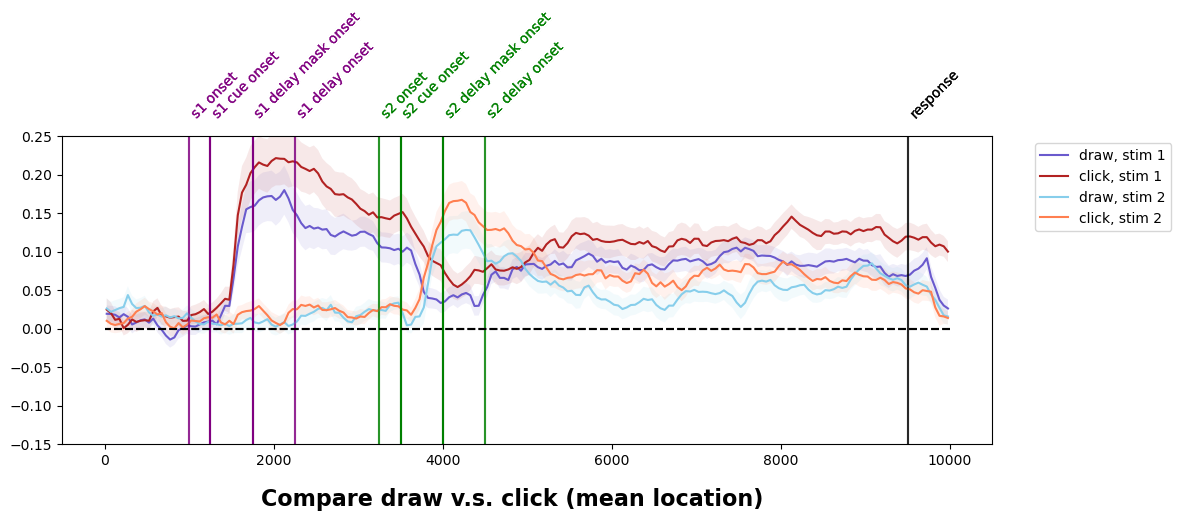

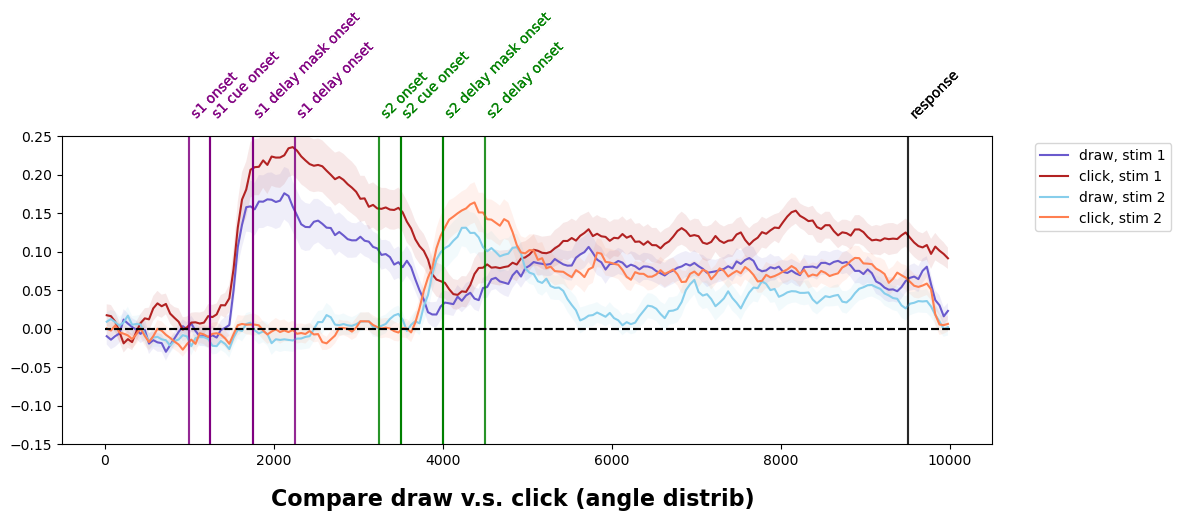

In [26]:
mode_masks = {
    'stim_1': {
        'draw, stim 1': draw_stim1_lmb,
        'click, stim 1': click_stim1_lmb,
    },
    'stim_2': {
        'draw, stim 2': draw_stim2_lmb,
        'click, stim 2': click_stim2_lmb,
    }
}

mode_colors = {
    'stim_1': {
        'draw, stim 1': 'slateblue',
        'click, stim 1': 'firebrick',
    },
    'stim_2': {
        'draw, stim 2': 'skyblue',
        'click, stim 2': 'coral',
    }
}

for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    to_show_legend = True
    for stim_id in ['stim_1', 'stim_2']:
        display_lmb_dicts_rsa(
            ax, mode_masks[stim_id], ALL_FEATURE_MASKS[feature_name], stim_id, 
            ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=mode_colors[stim_id], 
            show_legend=to_show_legend)
        # to_show_legend = False
    plt.suptitle(f'Compare draw v.s. click ({feature_name})', y=0, fontsize=16, fontweight='bold')

    plot_path = os.path.join(PLOTS_FOLDER, f'stim_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

100%|██████████| 33/33 [00:49<00:00,  1.50s/it]


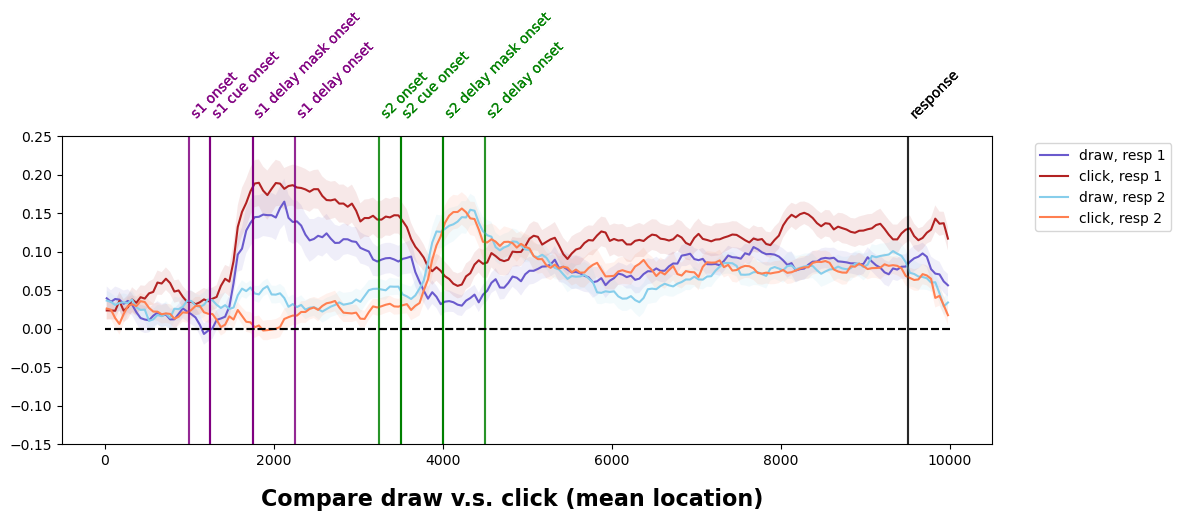

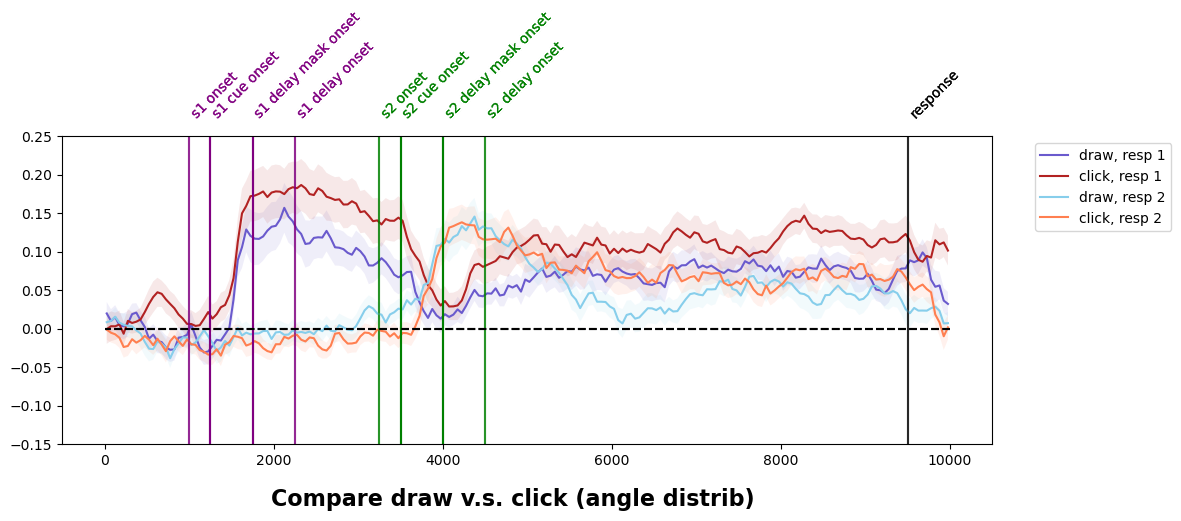

In [27]:
mode_masks = {
    'resp_1': {
        'draw, resp 1': draw_stim1_lmb,
        'click, resp 1': click_stim1_lmb,
    },
    'resp_2': {
        'draw, resp 2': draw_stim2_lmb,
        'click, resp 2': click_stim2_lmb,
    }
}

mode_colors = {
    'resp_1': {
        'draw, resp 1': 'slateblue',
        'click, resp 1': 'firebrick',
    },
    'resp_2': {
        'draw, resp 2': 'skyblue',
        'click, resp 2': 'coral',
    }
}

for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    to_show_legend = True
    for stim_id in ['resp_1', 'resp_2']:
        display_lmb_dicts_rsa(
            ax, mode_masks[stim_id], ALL_FEATURE_MASKS[feature_name], stim_id, 
            ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=mode_colors[stim_id], 
            show_legend=to_show_legend)
        # to_show_legend = False
    plt.suptitle(f'Compare draw v.s. click ({feature_name})', y=0, fontsize=16, fontweight='bold')

    plot_path = os.path.join(PLOTS_FOLDER, f'resp_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

100%|██████████| 33/33 [00:47<00:00,  1.43s/it]


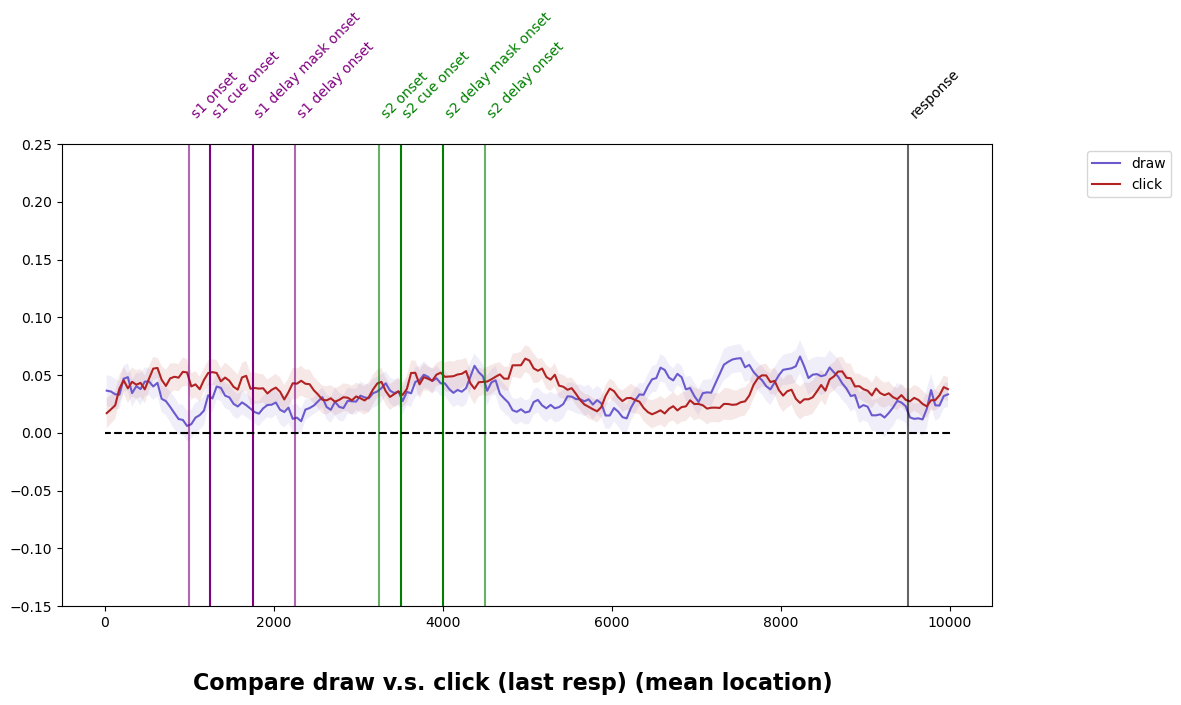

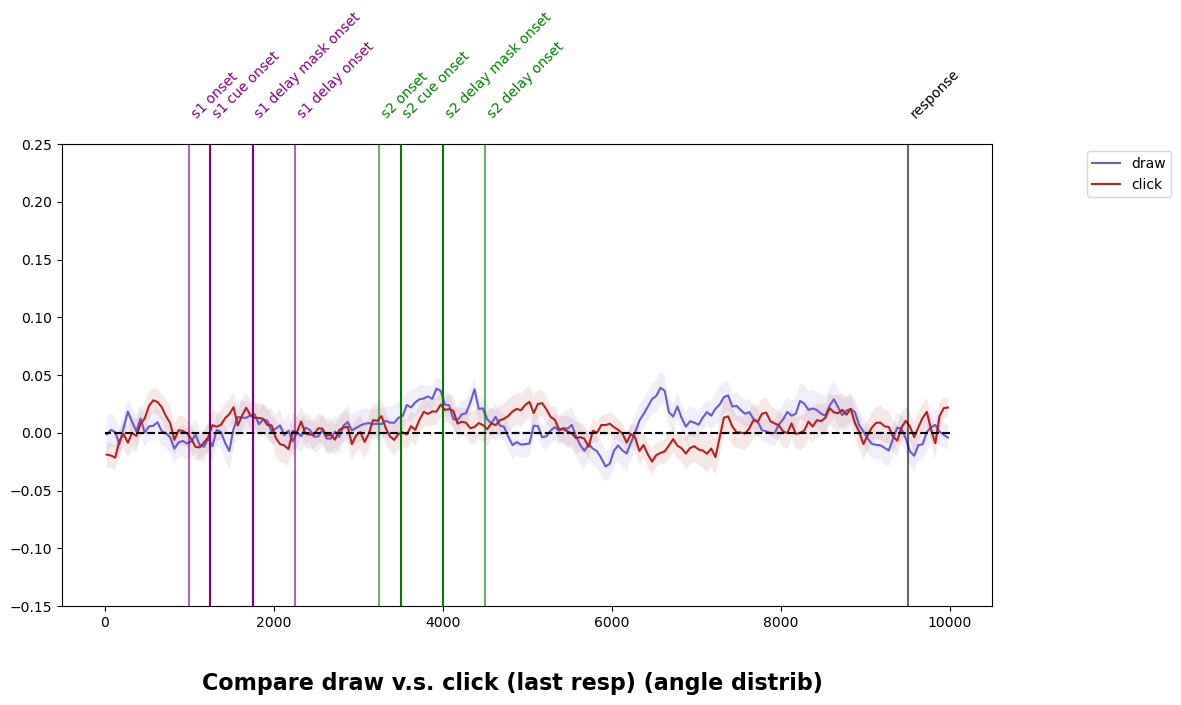

In [28]:
mode_masks = {
    'draw': draw_lmb,
    'click': click_lmb,
}

mode_colors = {
    'draw': 'slateblue',
    'click': 'firebrick',
}

for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    display_lmb_dicts_rsa(
        ax, mode_masks, ALL_FEATURE_MASKS[feature_name], 'prev_last_response', 
        ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=mode_colors)
    plt.suptitle(f'Compare draw v.s. click (last resp) ({feature_name})', y=0, fontsize=16, fontweight='bold')
    
    plot_path = os.path.join(PLOTS_FOLDER, f'last-resp_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

In [30]:
s1_cued_only = lambda df: ((df['trial_code']==0) & (df['stim_1_to_report']) & ~(df['stim_2_to_report'])).to_numpy()
both_cued_lmb = lambda df: ((df['trial_code']==0) & (df['stim_1_to_report']) & (df['stim_2_to_report'])).to_numpy()
null_cue_lmb = lambda df: (df['trial_code']==1).to_numpy()

### Analyze whether uncertainty matters

100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


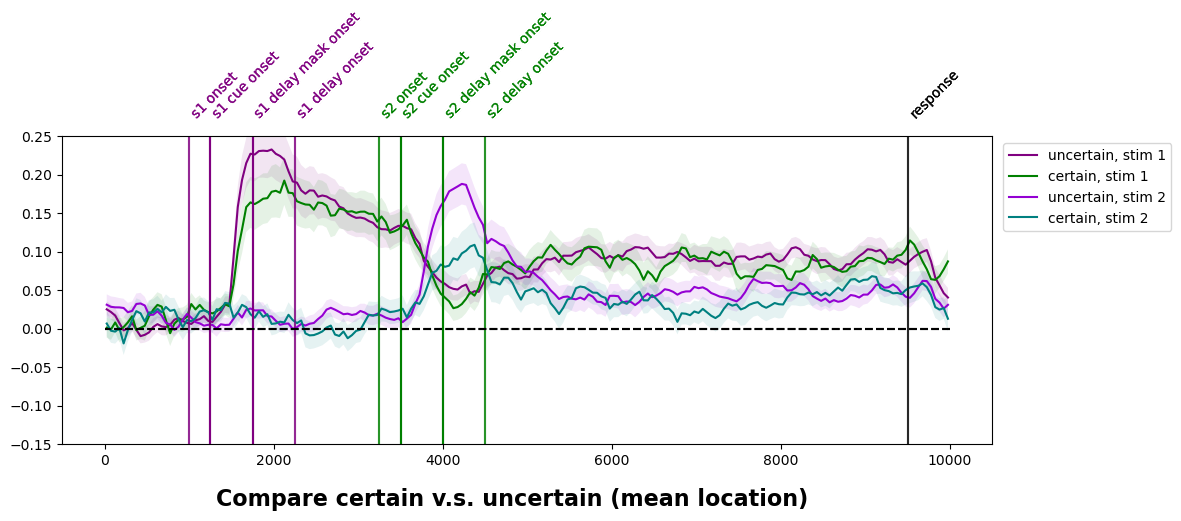

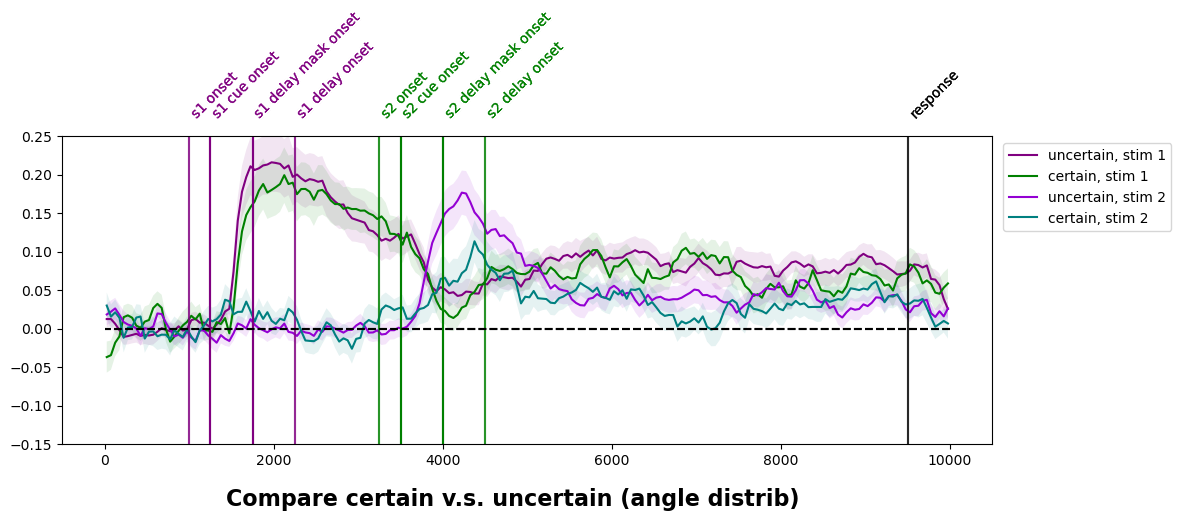

In [32]:
certainty_masks = {
    'stim_1': {
        'uncertain, stim 1': null_cue_lmb,
        'certain, stim 1': both_cued_lmb,
    },
    'stim_2': {
        'uncertain, stim 2': null_cue_lmb,
        'certain, stim 2': both_cued_lmb,
    }
}

certainty_colors = {
    'stim_1': {
        'uncertain, stim 1': 'purple',
        'certain, stim 1': 'green',
    },
    'stim_2': {
        'uncertain, stim 2': 'darkviolet',
        'certain, stim 2': 'teal',
    }
}

for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    to_show_legend = True
    for stim_id in ['stim_1', 'stim_2']:
        display_lmb_dicts_rsa(
            ax, certainty_masks[stim_id], ALL_FEATURE_MASKS[feature_name], stim_id, 
            ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=certainty_colors[stim_id], 
            show_legend=to_show_legend)
    plt.suptitle(f'Compare certain v.s. uncertain ({feature_name})', y=0, fontsize=16, fontweight='bold')
    plot_path = os.path.join(PLOTS_FOLDER, f'certainty_stim_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

100%|██████████| 33/33 [00:43<00:00,  1.31s/it]


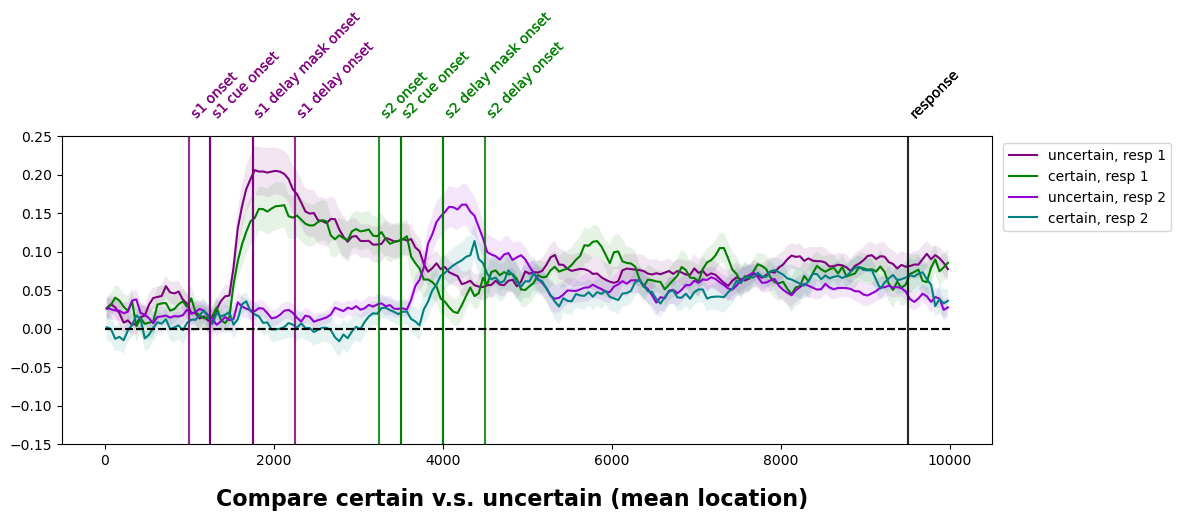

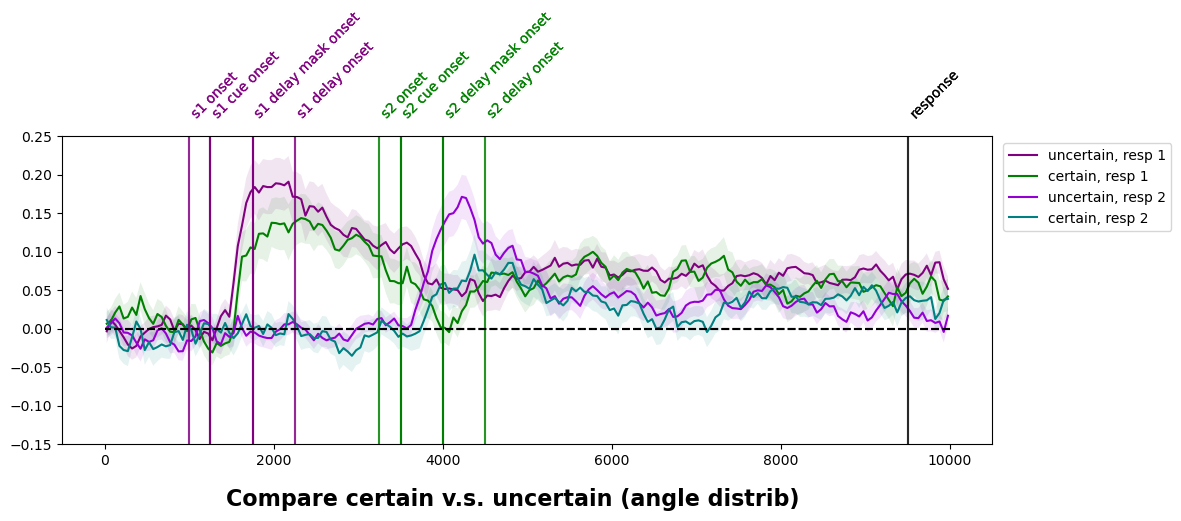

In [33]:
certainty_masks = {
    'resp_1': {
        'uncertain, resp 1': null_cue_lmb,
        'certain, resp 1': both_cued_lmb,
    },
    'resp_2': {
        'uncertain, resp 2': null_cue_lmb,
        'certain, resp 2': both_cued_lmb,
    }
}

certainty_colors = {
    'resp_1': {
        'uncertain, resp 1': 'purple',
        'certain, resp 1': 'green',
    },
    'resp_2': {
        'uncertain, resp 2': 'darkviolet',
        'certain, resp 2': 'teal',
    }
}

for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    to_show_legend = True
    for stim_id in ['resp_1', 'resp_2']:
        display_lmb_dicts_rsa(
            ax, certainty_masks[stim_id], ALL_FEATURE_MASKS[feature_name], stim_id, 
            ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=certainty_colors[stim_id], 
            show_legend=to_show_legend)
    plt.suptitle(f'Compare certain v.s. uncertain ({feature_name})', y=0, fontsize=16, fontweight='bold')
    plot_path = os.path.join(PLOTS_FOLDER, f'certainty_resp_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

100%|██████████| 33/33 [00:43<00:00,  1.33s/it]


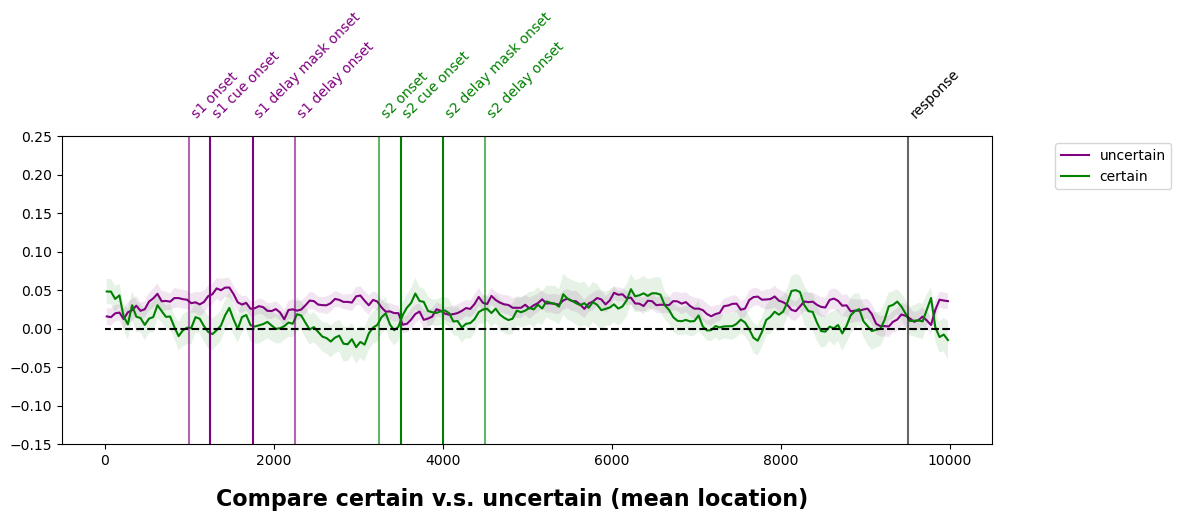

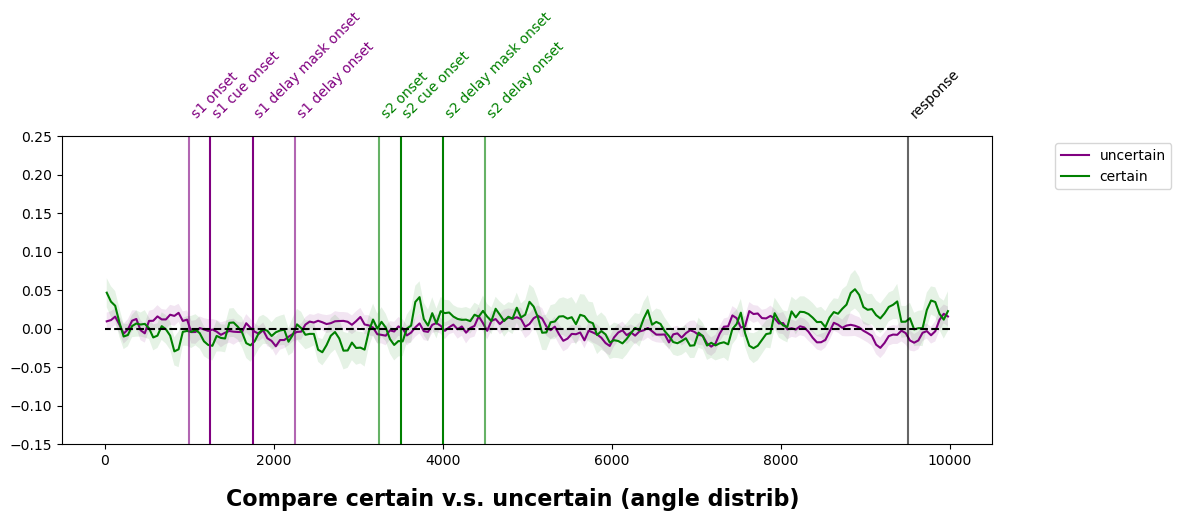

In [34]:
certainty_masks = {
    'uncertain': null_cue_lmb,
    'certain': both_cued_lmb,
}

certainty_colors = {
    'uncertain': 'purple',
    'certain': 'green',
}

for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    to_show_legend = True
    display_lmb_dicts_rsa(
        ax, certainty_masks, ALL_FEATURE_MASKS[feature_name], 'prev_last_response', 
        ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=certainty_colors, 
        show_legend=to_show_legend)
    plt.suptitle(f'Compare certain v.s. uncertain ({feature_name})', y=0, fontsize=16, fontweight='bold')
    plot_path = os.path.join(PLOTS_FOLDER, f'certainty_last-resp_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')